In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import glob
import re
import pathlib
import pandas as pd

from PIL import Image, ImageChops, ImageEnhance
from functools import partial
from SSIM_PIL import compare_ssim
from matplotlib.pyplot import imshow
from scipy.fftpack import dct, idct
from mlxtend.plotting import plot_confusion_matrix

No module named 'pyopencl'. cl12 version by Christoph Gohlke for windows is recommended: https://www.lfd.uci.edu/~gohlke/pythonlibs/#pyopencl


# ELA V.1

First attempt at Error Level Analysis algorithm (ELA image is the abs value of the diff b/w input and resaved -- as described in Neal Krawetz' paper)

In [2]:
def get_image_elaV1(input_img_path, resave_quality):
    
    input_img = Image.open(input_img_path)
    str_path = re.split(r'[\\.]', input_img_path)
    # resaving the input image under quality x
    resave_img_path = 'resaves/' + str_path[1] + '_resave_' + str(resave_quality) + '.jpg'
    input_img.save(resave_img_path, 'JPEG', quality = resave_quality)
    resave_img = Image.open(resave_img_path)
    
    # calculating ELA image as the diff in pixels b/w input image and resaved image across RGB channels
    ela_img = ImageChops.difference(input_img, resave_img)
    # scaling the ELA image
    pixel_ex = ela_img.getextrema()                    # pixel_ex = a tuple for each RHB channel with lowest and highest pixel
    max_pixel = max([ex[1] for ex in pixel_ex])        # max_pixel = highest pixel across all channels
    scale = 255.0/max_pixel
    ela_img = ImageEnhance.Brightness(ela_img).enhance(scale)
    
    ela_img_dir = 'elaV1/'+ str_path[1][:]
    pathlib.Path(ela_img_dir).mkdir(exist_ok=True) 
    ela_img_path = ela_img_dir + '/' + str_path[1] + '_ela_' + str(resave_quality) + 'V1.png'
    ela_img.save(ela_img_path, 'PNG')
    
    input_img.close()
    resave_img.close()
    
    return ela_img_path

In [3]:
#q = [95, 90, 85, 80, 75, 70]
#for i in q:
    #get_image_elaV1('images/test.jpg', i)

# ELA V.2

Second attempt at Error Level Analysis algorithm (edit: ELA image is the square of the diff b/w input and resaved)

In [4]:
def get_image_elaV2(input_img_path, resave_quality):
    
    input_img = Image.open(input_img_path) 
    str_path = re.split(r'[\\.]', input_img_path)
    # resaving the input image under quality x
    resave_img_path = 'resaves/' + str_path[1] + '_resave_' + str(resave_quality) + 'V2.jpg'
    input_img.save(resave_img_path, 'JPEG', quality = resave_quality)
    resave_img = Image.open(resave_img_path)
    
    # calculating ELA image as the diff in pixels b/w input image and resaved image across RGB channels
    imgA = np.array(input_img)
    imgB = np.array(resave_img)
    pixels = (imgA - imgB) ** 2
    ela_img = Image.fromarray(pixels.astype('uint8'), 'RGB')
    
    ela_img_dir = 'elaV2/'+ str_path[1][:]
    pathlib.Path(ela_img_dir).mkdir(exist_ok=True) 
    ela_img_path = ela_img_dir + '/' + str_path[1] + '_ela_' + str(resave_quality) + 'V2.png'
    ela_img.save(ela_img_path, 'PNG')

    input_img.close()
    resave_img.close()
    
    return ela_img_path

In [5]:
#q = [95, 90, 85, 80, 75, 70]
#for i in q:
    #get_image_elaV2('images/test.jpg', i)

# ELA V.3

Third attempt at Error Level Analysis algorithm (edit: ELA image is the square of the diff b/w DCT of input and DCT of resaved)

In [6]:
def d2_dct(block):
    
    return dct(dct(block.T, norm='ortho').T, norm='ortho')


def d2_idct(block):
    
    return idct(idct(block.T, norm='ortho').T, norm='ortho')


def dct_threshold(dct_block):
    
    thresh = np.median(dct_block)
    dct_block[dct_block<thresh] = 0 # Remove all the small coefficients
    
    return dct_block


# Block-based implementation of 2D Discrete Cosine Transform
def block_dct(img_path, w = 8) :  # w = block size
    
    img = Image.open(img_path) 
    img = img.convert("RGB")
    img = np.asarray(img, dtype=np.float64)
    r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
    
    img_size = img.shape
    dct = np.zeros(img_size)

    # Loop over the w by w blocks in each RGB channel
    for i in range(1,img_size[0]//w+1):
        for j in range(1,img_size[1]//w+1):
            
            dct[(i-1)*w: i*w, (j-1)*w: j*w, 0] = d2_dct(r[(i-1)*w: i*w, (j-1)*w: j*w])
            dct[(i-1)*w: i*w, (j-1)*w: j*w, 0] = dct_threshold(dct[(i-1)*w: i*w, (j-1)*w: j*w, 0])
            
            dct[(i-1)*w: i*w, (j-1)*w: j*w, 1] = d2_dct(g[(i-1)*w: i*w, (j-1)*w: j*w])
            dct[(i-1)*w: i*w, (j-1)*w: j*w, 1] = dct_threshold(dct[(i-1)*w: i*w, (j-1)*w: j*w, 1])
            
            dct[(i-1)*w: i*w, (j-1)*w: j*w, 2] = d2_dct(b[(i-1)*w: i*w, (j-1)*w: j*w])
            dct[(i-1)*w: i*w, (j-1)*w: j*w, 2] = dct_threshold(dct[(i-1)*w: i*w, (j-1)*w: j*w, 2])
            
    return dct


# Block-based implementation of inverse 2D Discrete Cosine Transform
def inv_block_dct(dct, w = 8) :  # w = block size
    
    img_size =  dct.shape
    in_dct = np.zeros(img_size, dtype='float64')

    # Loop over the w by w blocks in each RGB channel
    for i in range(1,img_size[0]//w+1):
        for j in range(1,img_size[1]//w+1):
            
            in_dct[(i-1)*w: i*w, (j-1)*w: j*w, 0] = d2_idct(dct[(i-1)*w: i*w, (j-1)*w: j*w, 0])
            in_dct[(i-1)*w: i*w, (j-1)*w: j*w, 1] = d2_idct(dct[(i-1)*w: i*w, (j-1)*w: j*w, 1])
            in_dct[(i-1)*w: i*w, (j-1)*w: j*w, 2] = d2_idct(dct[(i-1)*w: i*w, (j-1)*w: j*w, 2])
        
    in_dct = in_dct.clip(0, 255)
    in_dct = in_dct.astype("uint8")
    in_dct[in_dct<64] = 0
    img = Image.fromarray(in_dct)
    
    return img

In [7]:
def get_image_elaV3(input_img_path, resave_quality):
    
    # resaving the input image under quality x
    input_img = Image.open(input_img_path)
    str_path = re.split(r'[\\.]', input_img_path)
    resave_img_path = 'resaves/' + str_path[1] + '_resave_' + str(resave_quality) + 'V3.jpg'
    input_img.save(resave_img_path, 'JPEG', quality = resave_quality)
    
    # apply dct over input image and resaved image
    dct_input = block_dct(input_img_path)
    dct_resave = block_dct(resave_img_path)
    # calculate ELA image as the diff in pixels b/w the transformed input image and transformed resaved image
    diff = (dct_input - dct_resave)**2
    ela_img = inv_block_dct(diff)
    
    ela_img_dir = 'elaV3/'+ str_path[1][:]
    pathlib.Path(ela_img_dir).mkdir(exist_ok=True) 
    ela_img_path = ela_img_dir + '/' + str_path[1] + '_ela_' + str(resave_quality) + 'V3.png'
    ela_img.save(ela_img_path, 'PNG')
    
    input_img.close()
    
    return ela_img_path

In [8]:
#q = [95, 90, 85, 80, 75, 70]
#for i in q:
    #get_image_elaV3('images/test.jpg', 85)

# Evaluation

In [9]:
## TP: pixels in the border and/or inside that showed up and should show up      ##ex. nonblack-img with white-gt 
## TN: pixels that didn't show up and shouldn't show up                          ##ex. black-img with black-gt
## FP: pixels (with same intensity as border) that showed up but shouldn't have  ##ex. nonblack-img with black-gt
## FN: pixels in the border and/or inside that didn't show up but should have    ##ex. black-img with white-gt

def compare_mask_to_ela(mask, ela):
    
    tp = 0; tn = 0; fp = 0; fn = 0
    
    for i in range(0, mask.size[0]):
        for j in range(0, ela.size[1]):
            
            ela_rgb_pix = ela.getpixel((i,j))
            mask_rgb_pix = mask.getpixel((i,j))
            
            if(ela_rgb_pix.count(0) != 3 and mask_rgb_pix.count(255) == 3 ):
                tp = tp + 1
            elif(ela_rgb_pix.count(0) == 3 and mask_rgb_pix.count(0) == 3 ):
                tn = tn + 1
            elif(ela_rgb_pix.count(0) != 3 and mask_rgb_pix.count(0) == 3 ):
                fp = fp + 1
            elif(ela_rgb_pix.count(0) == 3 and mask_rgb_pix.count(255) == 3 ):
                fn = fn + 1     
    
    return tp, tn, fp, fn

In [10]:
def calculate_f1_score(tp, fp, fn):
    
    if (tp != 0 and fp != 0):
        precision = tp/(tp+fp)
    else:
        precision = 0
    
    if (tp != 0 and fn != 0): 
        recall = tp/(tp+fn)
    else:
        recall = 0
    
    if (tp != 0 and fp != 0 and fn != 0):
        f1_score = (2*tp) / ((2*tp) + fp +fn)
    else:
        f1_score = 0
    
    return f1_score, precision, recall


# Mathew Correlation Coefficient
def calculate_mcc(tp, tn, fp, fn):
    
    if(tp != 0 and tn != 0 and fp != 0 and fn != 0):
        mcc = ((tp*tn) - (fp*fn)) / math.sqrt((tp+fn) * (tp+fp) * (tn+fp) * (tn+fn))
    else:
        mcc = 0
    
    return mcc

In [11]:
def evaluate_results(ela_foldername):
    
    data = []
    binaries = []
    index_names = []
    
    mask_loc = glob.glob("masks/*")
    for mask_filename in mask_loc:
        
        mask = Image.open(mask_filename).convert('RGB')
        str_path = re.split(r'[\\.]', mask_filename)
    
        temp_data = []
        temp_binaries = []
        temp_index_names = []
        ela_loc = glob.glob(ela_foldername + "/*" + "tamp" + str_path[1][4:] + "/*")
        
        for ela_filename in ela_loc:
            
            print(ela_filename)
            ela = Image.open(ela_filename).convert('RGB')
            temp_index_names.append(re.split(r'[\\.]', ela_filename)[2])
            
            tp, tn, fp, fn = compare_mask_to_ela(mask, ela)
            print(tp, tn, fp, fn)
            temp_binaries.append([tp, tn, fp, fn])
            f1_score, precision, recall = calculate_f1_score(tp, fp, fn)
            mcc = calculate_mcc(tp, tn, fp, fn)
            
            temp_data.append([precision, recall, f1_score, mcc])
        
        temp_data = np.array(temp_data)
        temp_binaries = np.array(temp_binaries)
        index_max = np.argmax(temp_data[:,3:])
        data.append(temp_data[index_max,:])
        binaries.append(temp_binaries[index_max,:])
        index_names.append(temp_index_names[index_max])
    
    df_binaries = pd.DataFrame(binaries, index=index_names, columns=['TP', 'TN', 'FP', 'FN'])
    df_measures = pd.DataFrame(data, index=index_names, columns=['precision', 'recall', 'f1', 'mcc'])
    
    return df_measures, df_binaries

In [12]:
imgs_loc = glob.glob("imgs/*")
for img_filename in imgs_loc:
    q = [95, 90, 85, 80, 75, 70]
    for i in q:
        get_image_elaV1(img_filename, i)
        get_image_elaV2(img_filename, i)
        get_image_elaV3(img_filename, i)

In [13]:
dfV1_measures, dfV1_binaries = evaluate_results("elaV1")

elaV1\tamp1\tamp1_ela_70V1.png
6144 16677 73650 1833
elaV1\tamp1\tamp1_ela_75V1.png
6076 17275 73052 1901
elaV1\tamp1\tamp1_ela_80V1.png
5149 21044 69283 2828
elaV1\tamp1\tamp1_ela_85V1.png
4416 32350 57977 3561
elaV1\tamp1\tamp1_ela_90V1.png
3491 41397 48930 4486
elaV1\tamp1\tamp1_ela_95V1.png
2001 58529 31798 5976
elaV1\tamp10\tamp10_ela_70V1.png
5188 5204 231800 9
elaV1\tamp10\tamp10_ela_75V1.png
5179 6381 230623 18
elaV1\tamp10\tamp10_ela_80V1.png
5178 9015 227989 19
elaV1\tamp10\tamp10_ela_85V1.png
5177 12773 224231 20
elaV1\tamp10\tamp10_ela_90V1.png
5159 20505 216499 38
elaV1\tamp10\tamp10_ela_95V1.png
5025 59308 177696 172
elaV1\tamp11\tamp11_ela_70V1.png
13939 1826 82334 205
elaV1\tamp11\tamp11_ela_75V1.png
13851 4732 79428 293
elaV1\tamp11\tamp11_ela_80V1.png
13739 12252 71908 405
elaV1\tamp11\tamp11_ela_85V1.png
13498 9895 74265 646
elaV1\tamp11\tamp11_ela_90V1.png
13223 16317 67843 921
elaV1\tamp11\tamp11_ela_95V1.png
12507 27950 56210 1637
elaV1\tamp12\tamp12_ela_70V1.png


In [14]:
dfV1_measures

,precision,recall,f1,mcc
tamp1_ela_70V1,0.076998,0.770214,0.140001,-0.031540
tamp10_ela_95V1,0.027501,0.966904,0.053481,0.073101
tamp11_ela_95V1,0.182007,0.884262,0.301879,0.165557
tamp12_ela_90V1,0.099698,0.926593,0.180026,0.092470
tamp13_ela_95V1,0.049882,0.975781,0.094911,0.142549
tamp14_ela_80V1,0.108948,0.972504,0.195945,0.132755
tamp15_ela_95V1,0.039124,0.989006,0.075271,0.129878
tamp2_ela_95V1,0.146233,0.913434,0.252106,0.087945
tamp3_ela_95V1,0.064860,0.848917,0.120512,0.151355
tamp4_ela_95V1,0.029848,0.956168,0.057889,0.112087


In [15]:
dfV1_binaries

,TP,TN,FP,FN
tamp1_ela_70V1,6144,16677,73650,1833
tamp10_ela_95V1,5025,59308,177696,172
tamp11_ela_95V1,12507,27950,56210,1637
tamp12_ela_90V1,7927,18166,71583,628
tamp13_ela_95V1,2780,42503,52952,69
tamp14_ela_80V1,8630,18848,70582,244
tamp15_ela_95V1,2159,43097,53024,24
tamp2_ela_95V1,11913,15709,69553,1129
tamp3_ela_95V1,2860,53431,41235,509
tamp4_ela_95V1,1527,47075,49632,70


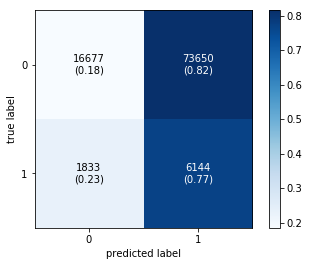

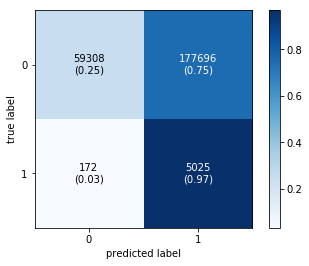

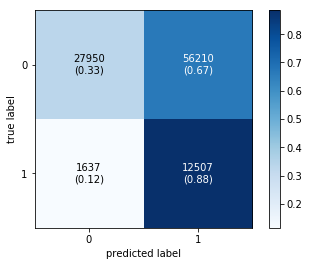

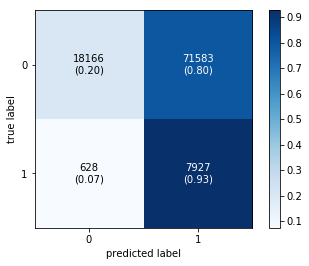

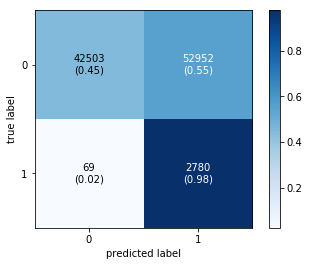

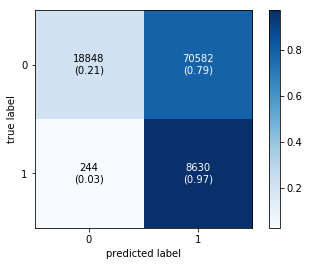

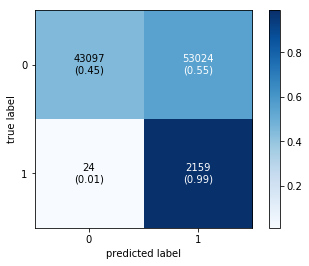

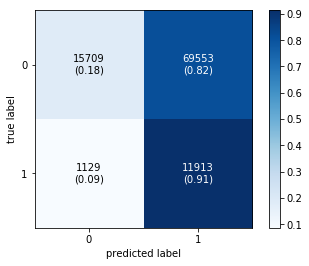

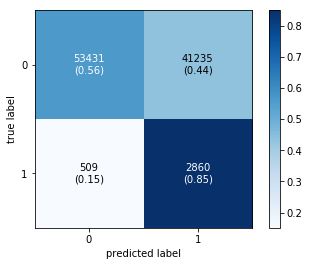

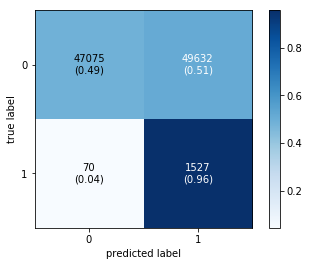

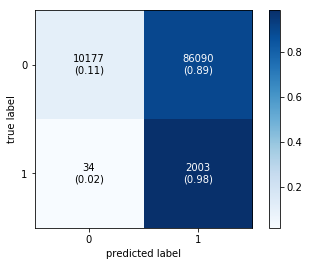

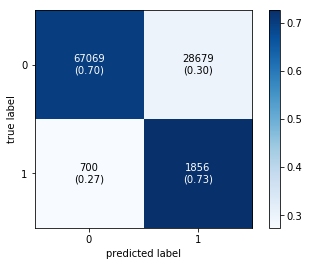

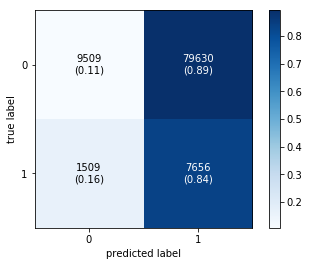

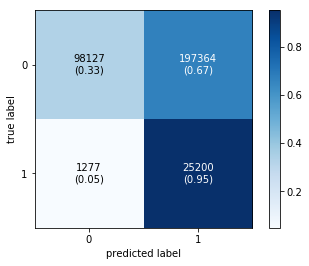

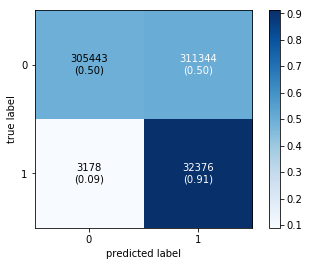

In [16]:
for index, row in dfV1_binaries.iterrows():
    binary = np.array([[int(row["TN"]), int(row["FP"])],
                       [int(row["FN"]), int(row["TP"])]])
    fig, ax = plot_confusion_matrix(conf_mat=binary,
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=True)
    plt.show()

In [17]:
dfV3_measures, dfV3_binaries = evaluate_results("elaV3")

elaV3\tamp1\tamp1_ela_70V3.png
618 82947 7380 7359
elaV3\tamp1\tamp1_ela_75V3.png
484 85891 4436 7493
elaV3\tamp1\tamp1_ela_80V3.png
393 89421 906 7584
elaV3\tamp1\tamp1_ela_85V3.png
161 90194 133 7816
elaV3\tamp1\tamp1_ela_90V3.png
0 90327 0 7977
elaV3\tamp1\tamp1_ela_95V3.png
0 90327 0 7977
elaV3\tamp10\tamp10_ela_70V3.png
2288 212774 24230 2909
elaV3\tamp10\tamp10_ela_75V3.png
2178 221950 15054 3019
elaV3\tamp10\tamp10_ela_80V3.png
1909 229801 7203 3288
elaV3\tamp10\tamp10_ela_85V3.png
1472 233419 3585 3725
elaV3\tamp10\tamp10_ela_90V3.png
1181 235221 1783 4016
elaV3\tamp10\tamp10_ela_95V3.png
646 236617 387 4551
elaV3\tamp11\tamp11_ela_70V3.png
4031 71967 12193 10113
elaV3\tamp11\tamp11_ela_75V3.png
3446 79886 4274 10698
elaV3\tamp11\tamp11_ela_80V3.png
2715 82898 1262 11429
elaV3\tamp11\tamp11_ela_85V3.png
2185 82427 1733 11959
elaV3\tamp11\tamp11_ela_90V3.png
1478 83162 998 12666
elaV3\tamp11\tamp11_ela_95V3.png
550 83454 706 13594
elaV3\tamp12\tamp12_ela_70V3.png
2442 69388 2036

In [18]:
dfV3_measures

,precision,recall,f1,mcc
tamp1_ela_80V3,0.302540,0.049267,0.084735,0.093825
tamp10_ela_90V3,0.398448,0.227246,0.289425,0.289586
tamp11_ela_80V3,0.682675,0.191954,0.299652,0.315221
tamp12_ela_90V3,0.707447,0.077732,0.140074,0.216271
tamp13_ela_85V3,0.541176,0.290628,0.378169,0.383908
tamp14_ela_80V3,0.560831,0.149087,0.235556,0.257476
tamp15_ela_90V3,0.723404,0.342648,0.465030,0.490621
tamp2_ela_85V3,0.752215,0.188775,0.301808,0.338949
tamp3_ela_80V3,0.453488,0.138914,0.212679,0.237314
tamp4_ela_80V3,0.813859,0.375078,0.513502,0.547983


In [19]:
dfV3_binaries

,TP,TN,FP,FN
tamp1_ela_80V3,393,89421,906,7584
tamp10_ela_90V3,1181,235221,1783,4016
tamp11_ela_80V3,2715,82898,1262,11429
tamp12_ela_90V3,665,89474,275,7890
tamp13_ela_85V3,828,94753,702,2021
tamp14_ela_80V3,1323,88394,1036,7551
tamp15_ela_90V3,748,95835,286,1435
tamp2_ela_85V3,2462,84451,811,10580
tamp3_ela_80V3,468,94102,564,2901
tamp4_ela_80V3,599,96570,137,998


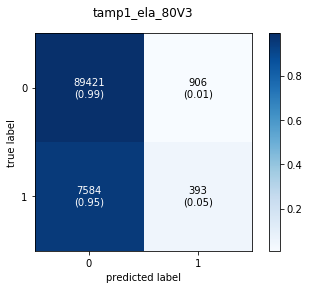

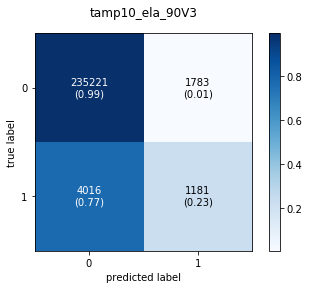

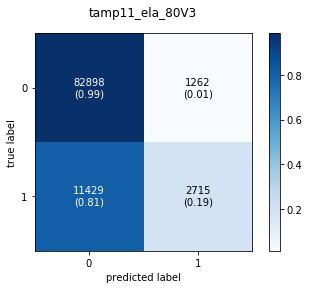

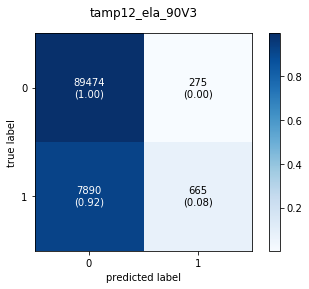

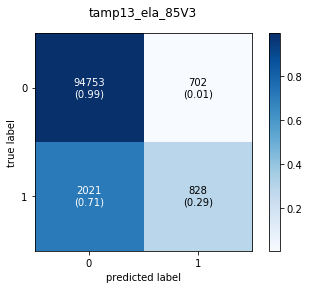

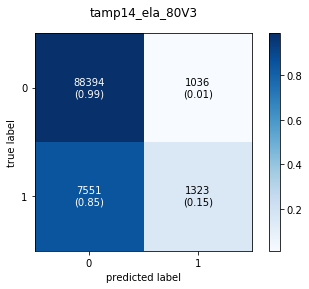

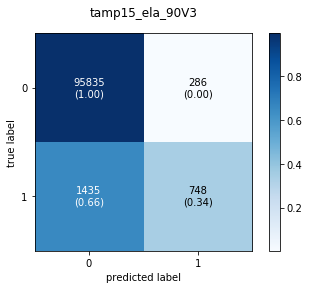

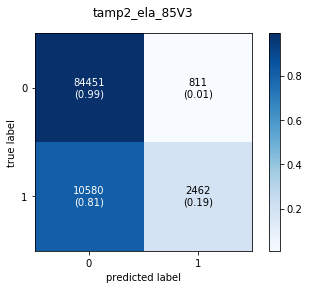

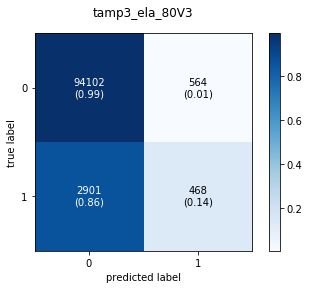

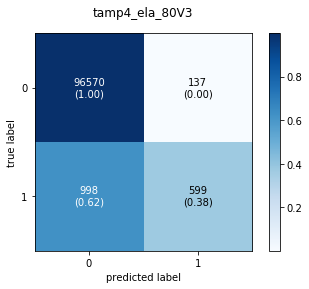

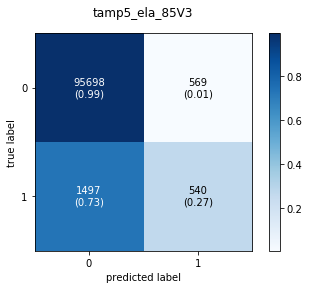

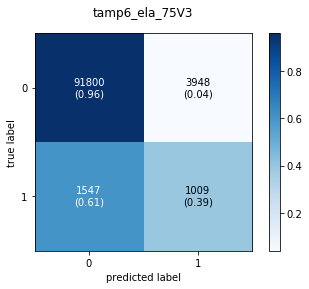

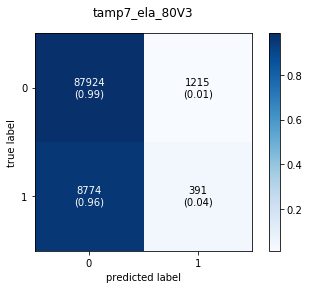

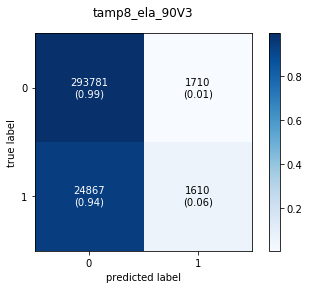

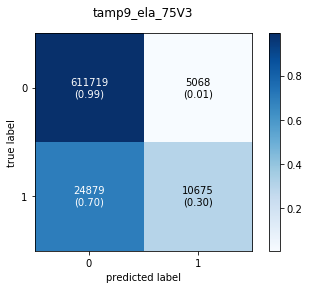

In [20]:
for index, row in dfV3_binaries.iterrows():
    binary = np.array([[int(row["TN"]), int(row["FP"])],
                       [int(row["FN"]), int(row["TP"])]])
    fig, ax = plot_confusion_matrix(conf_mat=binary,
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=True)
    plt.title(index)
    plt.show()

# Overlay

In [100]:
def get_ela_overlay(input_img_path, ela_img_path):
    
    input_img = Image.open(input_img_path)
    ela_img = Image.open(ela_img_path)
    
    input_img = input_img.convert('RGBA')
    ela_img = ela_img.convert('RGBA')
    
    ela_overlay_img = Image.blend(input_img, ela_img, 0.6)
    
    #plt.figure()
    #plt.imshow(ela_overlay_img)
    
    input_img.close()
    ela_img.close()
    return ela_overlay_img